In [1]:
import wave,os,librosa,tqdm,time,warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from cuml.svm import SVC as cuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import IPython.display as ipd

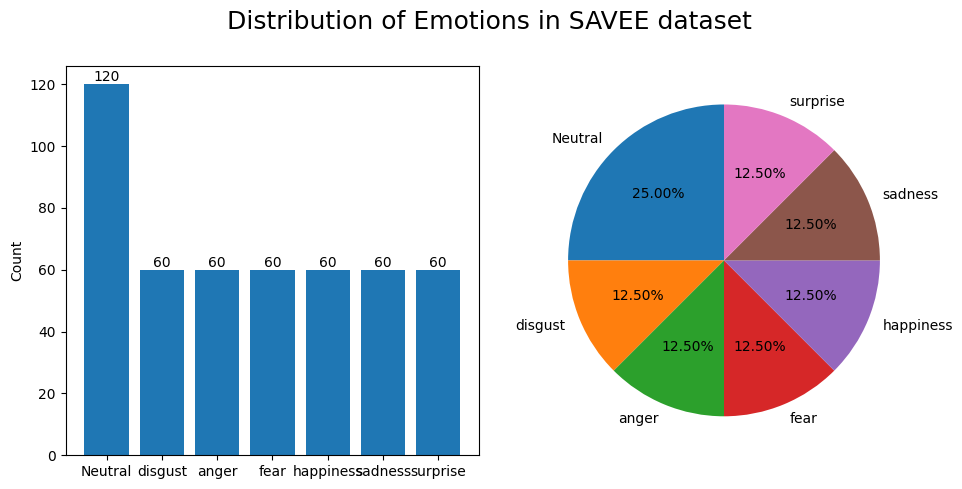

In [2]:
df = pd.read_csv('/kaggle/input/savee-opensmile-features/SAVEE_OpenSMILE_Features.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(df['label'].value_counts().index, df['label'].value_counts().values)
plt.ylabel("Count")
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),bar.get_height(), ha='center', va='bottom')
plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie',autopct='%1.2f%%',startangle=90)
plt.ylabel('')
plt.suptitle('Distribution of Emotions in SAVEE dataset', fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

In [3]:
df.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,2.978726,0.968750,0.347656,0.328570,0.750619,1.324610,0.422049,0.573991,0.996040,0.023396,...,0.380574,3.375247,3.417238,-19.032806,0.649769,161.56240,114.940010,126.396385,67.397354,anger
1,3.515860,0.897321,0.977679,0.469744,0.985246,1.966232,0.515501,0.980987,1.496488,0.008914,...,0.660687,3.718355,3.657718,18.473469,0.326906,149.85840,81.596756,136.289580,52.223125,anger
2,5.020127,0.829787,0.223404,0.959607,1.461268,2.921162,0.501661,1.459894,1.961555,0.167534,...,0.421897,3.206596,3.279883,-17.526520,0.486361,123.96335,78.017240,129.438220,43.460830,anger
3,3.276954,0.916350,0.285171,0.281238,0.813517,1.696226,0.532279,0.882709,1.414988,0.008405,...,0.623725,3.269035,3.304243,-19.262568,0.349550,162.02300,80.544530,127.006065,62.164104,anger
4,4.864303,0.837037,0.000000,1.186194,1.713518,3.411065,0.527324,1.697547,2.224870,0.460590,...,0.404139,3.682561,3.822313,-15.601704,0.524379,143.29222,64.899960,138.074810,72.790800,anger


In [14]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True,hppms=None):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name in ['XGBoost','SVM']:
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  if name in ['XGBoost','SVM']:
      if isinstance(trainY, pd.Series):
          trainY = trainY.to_numpy().astype(np.int32)
          testY = testY.to_numpy().astype(np.int32)
      else:
          trainY = trainY.astype(np.int32)
          testY = testY.astype(np.int32)
  model.fit(trainX, trainY)
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

In [5]:
def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [25]:
def getRandparams(mname):
    if mname == 'SVM':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.01), np.log10(10)),
            'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.0003)),
            'coef0': 10**np.random.uniform(0, np.log10(0.1)),
            'class_weight': np.random.choice(['balanced', None]),
            'multiclass_strategy': np.random.choice(['ovo', 'ovr']),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'XGBoost':
        model_params = {
            'learning_rate': np.random.uniform(0.01, 0.5),
            'n_estimators': np.random.randint(50, 200),
            'max_depth': np.random.randint(3, 20),
            'min_child_weight': np.random.randint(1, 10),
            'gamma': np.random.uniform(0, 1),
            'subsample': np.random.uniform(0.3, 1),
            'colsample_bytree': np.random.uniform(0.5, 1),
            'reg_alpha': np.random.uniform(0, 1),
            'reg_lambda': np.random.uniform(0, 1),
            'scale_pos_weight': np.random.uniform(1, 15),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'LogisticRegression':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.1), np.log10(0.5)),
            'solver': np.random.choice(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            'class_weight': np.random.choice(['balanced', None]),
            'penalty': np.random.choice(['l1', 'l2', 'elasticnet', None]),
            'random_state': np.random.randint(0, 1000),
        }
        if model_params['solver'] in ['lbfgs','newton-cg','sag']:
            model_params['penalty'] = np.random.choice(['l2', None])
        if model_params['solver'] == 'liblinear':
            model_params['penalty'] = np.random.choice(['l1', 'l2'])
        if model_params.get('penalty') == 'elasticnet':
            model_params['l1_ratio'] = np.random.uniform(0.0, 1.0)
        
    elif mname == 'RandomForest':
        model_params = {
            'n_estimators': np.random.randint(100, 200),
            'max_depth': np.random.choice([np.random.randint(10, 50),None]),
            'min_samples_split': np.random.randint(2, 5),
            'min_samples_leaf': np.random.randint(1, 5),
            'max_features': np.random.choice(['sqrt', 'log2', None]),
            'class_weight': np.random.choice(['balanced', 'balanced_subsample', None]),
            'random_state': 71,
        }
    elif mname == 'KNN':
        model_params = {
            'n_neighbors': np.random.randint(3, 40),
            'weights': np.random.choice(['uniform', 'distance']),
            'algorithm': np.random.choice(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': np.random.randint(20, 50),
            'p': np.random.choice([1, 2]),  # Minkowski metric (p=1 for Manhattan, p=2 for Euclidean)
        }
    elif mname == 'DecisionTree':
        model_params = {
            'criterion': np.random.choice(['gini', 'entropy', 'log_loss']),
            'splitter': np.random.choice(['best', 'random']),
            'max_depth': np.random.randint(3, 50),
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice([None, 'sqrt', 'log2']),
            'random_state': np.random.randint(0, 1000)
        }
    elif mname == 'NaiveBayes':
        model_params = {
            'var_smoothing': 1e-9
        }
    elif mname == 'AdaBoost':
        model_params = {
            'n_estimators': np.random.randint(50, 100),
            'learning_rate': np.random.uniform(0,2),
            'random_state': np.random.randint(0, 1000)
        }
    else:
        raise ValueError(f"Unsupported model name: {mname}")
    
    return model_params

In [7]:
def tune_ML_hppms(mname,model,iters=20,rs=None,apply_smote=None,apply_LDA=None):
    hpr = []
    max_acc = 0
    best_model_params,best_prep_params,phist = dict(),dict(),dict()
    st0 = time.time()
    all_params = dict()
    for k in range(iters):
        st = time.time()
        model_params = getRandparams(mname)
        rs2 = rs if rs else np.random.randint(0, 1000)
        smote = apply_smote if apply_smote is not None else np.random.choice([True,False])
        lda = apply_LDA if apply_LDA is not None else np.random.choice([True,False])
        prep_params = {'rs': rs2,
                       'apply_smote': smote,
                        'apply_LDA': lda}
        all_params = {**model_params, **prep_params}
        fparams = frozenset(all_params.items())
        #update model params
        model.set_params(**model_params)
        print(f"Iter No. - {k}")
        print(f"Model Params = {model_params}")
        print(f"Preprocessing Params = {prep_params}")
        acc = preprocess_split_train_test(df,model,mname,**prep_params,printres=False)
        en = time.time()
        tm = en-st
        tm0 = en-st0
        print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
        ipd.clear_output(wait=True)
        print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
        phist[fparams] = acc
        if acc>max_acc:
            max_acc = acc
            best_model_params = model_params
            best_prep_params = prep_params
            best_iter = k
        print(f"\nCurrent Accuracy = {acc*100:.2f}%")
        print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
        print(f"Best Model Params Found so far = {best_model_params}\n")
        print(f"Best Preprocessing Params Found so far = {best_prep_params}\n")
    print("Hyperparameter Tuning Done!")
    model.set_params(**best_model_params)
    acc = preprocess_split_train_test(df,model,mname,**best_prep_params)
    return max_acc,best_model_params,best_prep_params,phist

Total Time taken = 7 min 15 sec

Current Accuracy = 58.33%
Best Accuracy = 68.75% at iter=53
Best Model Params Found so far = {'learning_rate': 0.4942555152887217, 'n_estimators': 190, 'max_depth': 13, 'min_child_weight': 8, 'gamma': 0.47244423388116497, 'subsample': 0.43712824870511924, 'colsample_bytree': 0.6299453983627274, 'reg_alpha': 0.6829549677964053, 'reg_lambda': 0.6788825238989239, 'scale_pos_weight': 12.47676717616645, 'random_state': 247}

Best Preprocessing Params Found so far = {'rs': 6, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


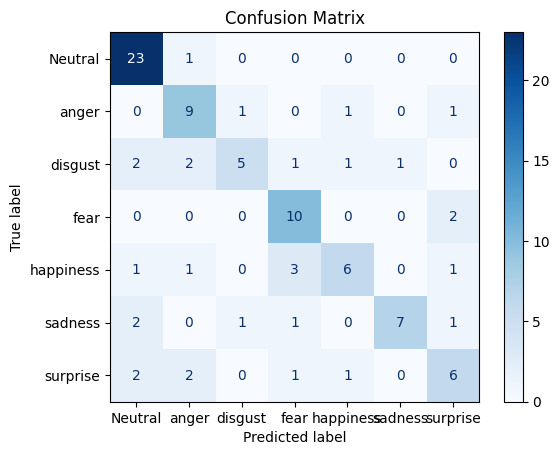


XGBoost Accuracy: 68.750%
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        24
           1       0.60      0.75      0.67        12
           2       0.71      0.42      0.53        12
           3       0.62      0.83      0.71        12
           4       0.67      0.50      0.57        12
           5       0.88      0.58      0.70        12
           6       0.55      0.50      0.52        12

    accuracy                           0.69        96
   macro avg       0.68      0.65      0.65        96
weighted avg       0.69      0.69      0.68        96



In [20]:
xgb_model = XGBClassifier(device='cuda')
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('XGBoost',xgb_model,iters=100,rs=6)

Total Time taken = 6 min 31 sec

Current Accuracy = 60.42%
Best Accuracy = 70.83% at iter=72
Best Model Params Found so far = {'n_neighbors': 35, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 43, 'p': 2}

Best Preprocessing Params Found so far = {'rs': 631, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


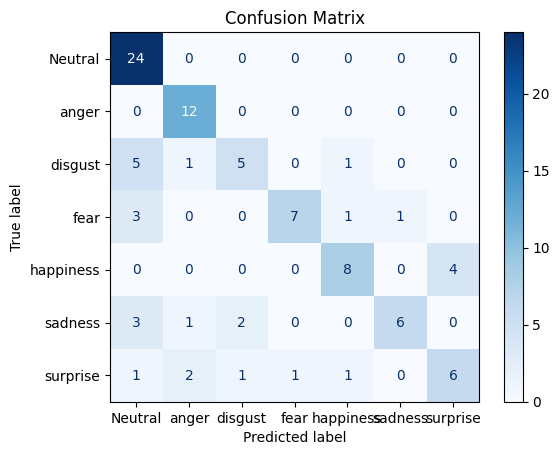


KNN Accuracy: 70.833%
              precision    recall  f1-score   support

     Neutral       0.67      1.00      0.80        24
       anger       0.75      1.00      0.86        12
     disgust       0.62      0.42      0.50        12
        fear       0.88      0.58      0.70        12
   happiness       0.73      0.67      0.70        12
     sadness       0.86      0.50      0.63        12
    surprise       0.60      0.50      0.55        12

    accuracy                           0.71        96
   macro avg       0.73      0.67      0.68        96
weighted avg       0.72      0.71      0.69        96



In [34]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=500)

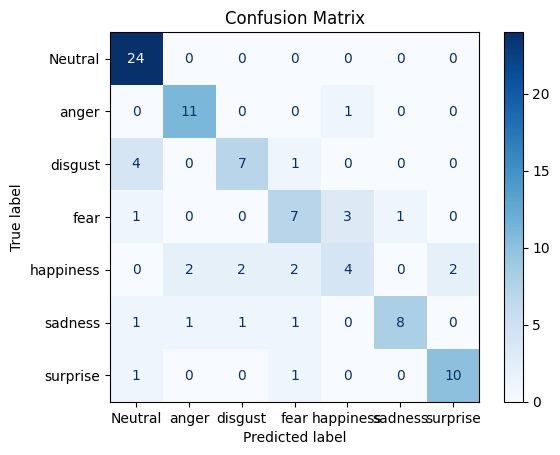


Random Forest Accuracy: 73.958%
              precision    recall  f1-score   support

     Neutral       0.77      1.00      0.87        24
       anger       0.79      0.92      0.85        12
     disgust       0.70      0.58      0.64        12
        fear       0.58      0.58      0.58        12
   happiness       0.50      0.33      0.40        12
     sadness       0.89      0.67      0.76        12
    surprise       0.83      0.83      0.83        12

    accuracy                           0.74        96
   macro avg       0.72      0.70      0.70        96
weighted avg       0.73      0.74      0.73        96



In [8]:
rf_model = RandomForestClassifier(n_estimators=150,random_state=71)
acc_rf = preprocess_split_train_test(df,rf_model,'Random Forest',apply_smote=True,apply_LDA=False,rs=78)

Total Time taken = 19 min 0 sec

Current Accuracy = 55.21%
Best Accuracy = 70.83% at iter=11
Best Model Params Found so far = {'n_estimators': 178, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': None, 'random_state': 71}

Best Preprocessing Params Found so far = {'rs': 78, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


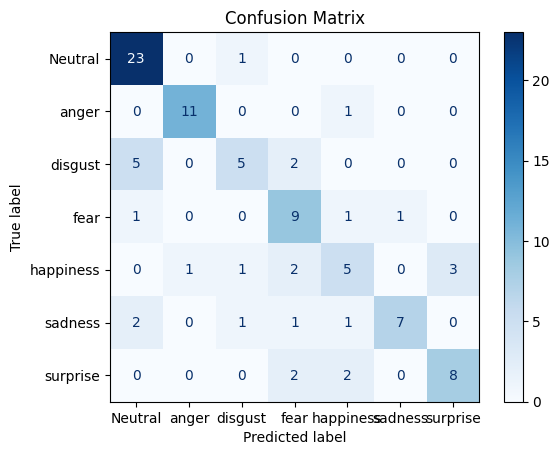


RandomForest Accuracy: 70.833%
              precision    recall  f1-score   support

     Neutral       0.74      0.96      0.84        24
       anger       0.92      0.92      0.92        12
     disgust       0.62      0.42      0.50        12
        fear       0.56      0.75      0.64        12
   happiness       0.50      0.42      0.45        12
     sadness       0.88      0.58      0.70        12
    surprise       0.73      0.67      0.70        12

    accuracy                           0.71        96
   macro avg       0.71      0.67      0.68        96
weighted avg       0.71      0.71      0.70        96



In [15]:
rf_model = RandomForestClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('RandomForest',rf_model,iters=20,rs=78,apply_LDA=False,apply_smote=True)

Total Time taken = 13 min 49 sec

Current Accuracy = 40.62%
Best Accuracy = 63.54% at iter=134
Best Model Params Found so far = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None, 'random_state': 409}

Best Preprocessing Params Found so far = {'rs': 966, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


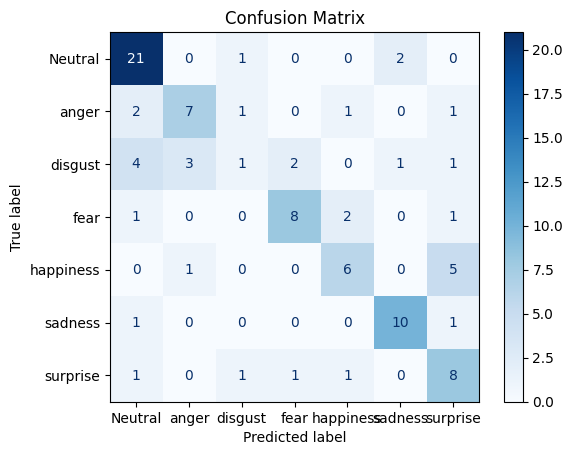


DecisionTree Accuracy: 63.542%
              precision    recall  f1-score   support

     Neutral       0.70      0.88      0.78        24
       anger       0.64      0.58      0.61        12
     disgust       0.25      0.08      0.12        12
        fear       0.73      0.67      0.70        12
   happiness       0.60      0.50      0.55        12
     sadness       0.77      0.83      0.80        12
    surprise       0.47      0.67      0.55        12

    accuracy                           0.64        96
   macro avg       0.59      0.60      0.59        96
weighted avg       0.61      0.64      0.61        96



In [19]:
dt_model = DecisionTreeClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('DecisionTree',dt_model,iters=1000)

Total Time taken = 9 min 5 sec

Current Accuracy = 79.17%
Best Accuracy = 79.17% at iter=24
Best Model Params Found so far = {'C': 0.142117044334229, 'solver': 'newton-cg', 'class_weight': None, 'penalty': 'l2', 'random_state': 388}

Best Preprocessing Params Found so far = {'rs': 6, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


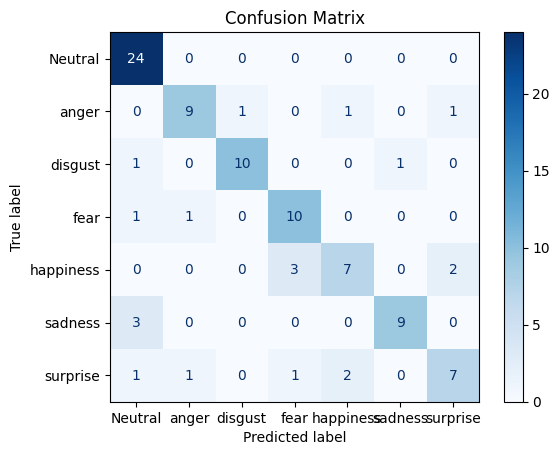


LogisticRegression Accuracy: 79.167%
              precision    recall  f1-score   support

     Neutral       0.80      1.00      0.89        24
       anger       0.82      0.75      0.78        12
     disgust       0.91      0.83      0.87        12
        fear       0.71      0.83      0.77        12
   happiness       0.70      0.58      0.64        12
     sadness       0.90      0.75      0.82        12
    surprise       0.70      0.58      0.64        12

    accuracy                           0.79        96
   macro avg       0.79      0.76      0.77        96
weighted avg       0.79      0.79      0.79        96



In [47]:
lr_model = LogisticRegression()
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('LogisticRegression',lr_model,iters=100,rs=6,apply_LDA=False,apply_smote=True)

In [48]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df2 = pd.DataFrame(data)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2[[col for col in sorted(df2.columns) if col != 'accuracy'] + ['accuracy']]
df2.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df2

,C,apply_LDA,apply_smote,class_weight,l1_ratio,penalty,random_state,rs,solver,accuracy
0,0.299463,False,True,balanced,NaN,l2,417,6,newton-cg,0.791667
1,0.142117,False,True,None,NaN,l2,388,6,newton-cg,0.791667
2,0.250402,False,True,None,NaN,l2,687,6,lbfgs,0.791667
3,0.509233,False,True,balanced,NaN,l2,869,6,lbfgs,0.781250
4,0.334238,False,True,balanced,NaN,l2,478,6,lbfgs,0.781250
...,...,...,...,...,...,...,...,...,...,...
95,1.912037,True,True,None,NaN,l2,831,6,liblinear,0.635417
96,0.715554,True,True,None,NaN,l2,540,6,liblinear,0.635417
97,0.352471,False,True,None,NaN,l1,814,6,liblinear,0.625000
98,1.188128,False,True,None,NaN,l1,477,6,liblinear,0.593750


In [49]:
numerical_features = df2.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df2.select_dtypes(include=['object', 'category','bool'])
correlation_matrix = numerical_features.corrwith(df2['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

l1_ratio        0.262122
random_state    0.049076
C              -0.156827
rs                   NaN
dtype: float64


In [50]:
categorical_features['accuracy'] = df2['accuracy']
for col in categorical_features.columns[:-1]:
    print(categorical_features.groupby(col)['accuracy'].mean())

apply_LDA
False    0.728423
True     0.657507
Name: accuracy, dtype: float64
apply_smote
True    0.687292
Name: accuracy, dtype: float64
class_weight
balanced    0.686042
Name: accuracy, dtype: float64
penalty
elasticnet    0.668750
l1            0.639881
l2            0.697917
Name: accuracy, dtype: float64
solver
lbfgs        0.711504
liblinear    0.645833
newton-cg    0.700521
sag          0.702381
saga         0.674479
Name: accuracy, dtype: float64


Total Time taken = 33 min 6 sec

Current Accuracy = 75.00%
Best Accuracy = 79.17% at iter=4
Best Model Params Found so far = {'C': 0.12203763465383484, 'solver': 'lbfgs', 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 696}

Best Preprocessing Params Found so far = {'rs': 6, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


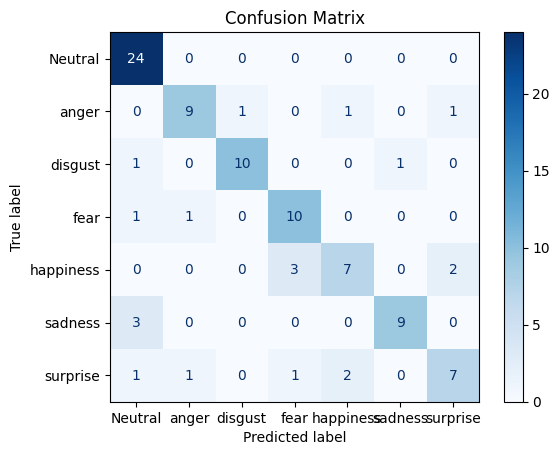


LogisticRegression Accuracy: 79.167%
              precision    recall  f1-score   support

     Neutral       0.80      1.00      0.89        24
       anger       0.82      0.75      0.78        12
     disgust       0.91      0.83      0.87        12
        fear       0.71      0.83      0.77        12
   happiness       0.70      0.58      0.64        12
     sadness       0.90      0.75      0.82        12
    surprise       0.70      0.58      0.64        12

    accuracy                           0.79        96
   macro avg       0.79      0.76      0.77        96
weighted avg       0.79      0.79      0.79        96



In [15]:
lr_model = LogisticRegression()
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('LogisticRegression',lr_model,iters=150,rs=6,apply_LDA=False,apply_smote=True)

Total Time taken = 5 min 17 sec

Current Accuracy = 57.29%
Best Accuracy = 70.83% at iter=360
Best Model Params Found so far = {'var_smoothing': 1e-09}

Best Preprocessing Params Found so far = {'rs': 588, 'apply_smote': True, 'apply_LDA': True}

Hyperparameter Tuning Done!


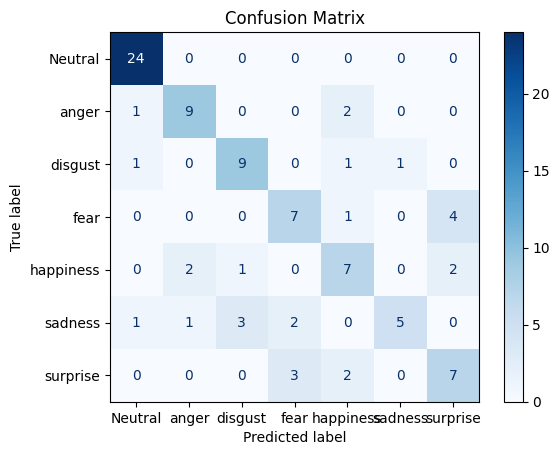


NaiveBayes Accuracy: 70.833%
              precision    recall  f1-score   support

     Neutral       0.89      1.00      0.94        24
       anger       0.75      0.75      0.75        12
     disgust       0.69      0.75      0.72        12
        fear       0.58      0.58      0.58        12
   happiness       0.54      0.58      0.56        12
     sadness       0.83      0.42      0.56        12
    surprise       0.54      0.58      0.56        12

    accuracy                           0.71        96
   macro avg       0.69      0.67      0.67        96
weighted avg       0.71      0.71      0.70        96



In [18]:
nb_model = GaussianNB()
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('NaiveBayes',nb_model,iters=500)

Total Time taken = 3 min 37 sec

Current Accuracy = 65.62%
Best Accuracy = 76.04% at iter=41
Best Model Params Found so far = {'C': 3.540096993681772, 'gamma': 6.304456448623689e-05, 'coef0': 0.26453765679953745, 'class_weight': None, 'multiclass_strategy': 'ovr', 'random_state': 585}

Best Preprocessing Params Found so far = {'rs': 6, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


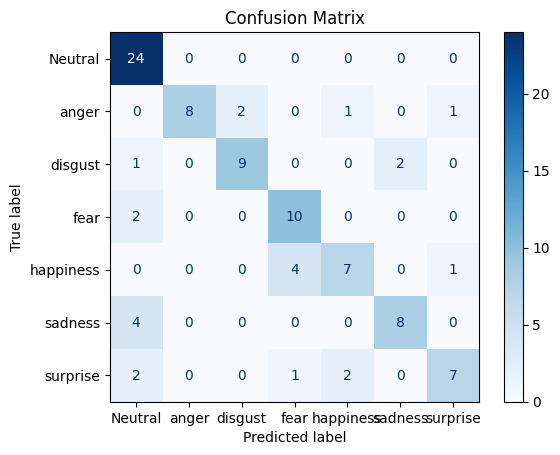


SVM Accuracy: 76.042%
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        24
           1       1.00      0.67      0.80        12
           2       0.82      0.75      0.78        12
           3       0.67      0.83      0.74        12
           4       0.70      0.58      0.64        12
           5       0.80      0.67      0.73        12
           6       0.78      0.58      0.67        12

    accuracy                           0.76        96
   macro avg       0.78      0.73      0.74        96
weighted avg       0.78      0.76      0.75        96



In [10]:
svm_model = cuSVC()
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('SVM',svm_model,iters=100,rs=6,apply_LDA=False,apply_smote=True)

Total Time taken = 63 min 17 sec

Current Accuracy = 72.92%
Best Accuracy = 72.92% at iter=0
Best Model Params Found so far = {'n_estimators': 87, 'learning_rate': 0.9369107320709811, 'random_state': 622}

Best Preprocessing Params Found so far = {'rs': 6, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


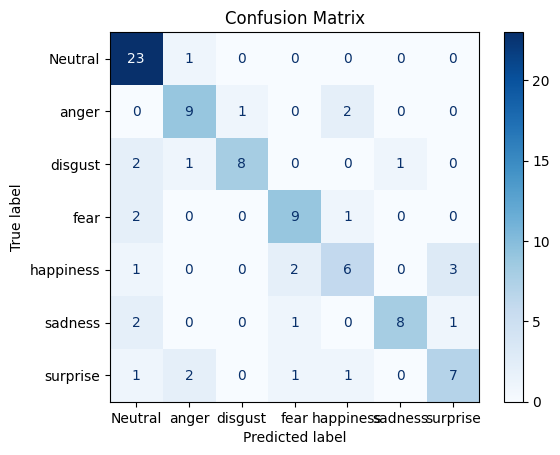


AdaBoost Accuracy: 72.917%
              precision    recall  f1-score   support

     Neutral       0.74      0.96      0.84        24
       anger       0.69      0.75      0.72        12
     disgust       0.89      0.67      0.76        12
        fear       0.69      0.75      0.72        12
   happiness       0.60      0.50      0.55        12
     sadness       0.89      0.67      0.76        12
    surprise       0.64      0.58      0.61        12

    accuracy                           0.73        96
   macro avg       0.73      0.70      0.71        96
weighted avg       0.74      0.73      0.72        96



In [28]:
blr_model = LogisticRegression(**{'C': 0.12203763465383484,
                                  'solver': 'lbfgs', 'class_weight': 'balanced',
                                  'penalty': 'l2', 'random_state': 696})
ab_model = AdaBoostClassifier(estimator=blr_model)
max_acc,best_model_params,best_prep_params,phist = tune_ML_hppms('AdaBoost',ab_model,iters=20,
                                                                 **{'rs': 6, 'apply_smote': True, 'apply_LDA': False})